# Smart Distribution Systems (B-KUL-H00P3A) 
Prof. Geert Deconinck

This exercise session will familiarize the students with basic concepts from machine learning and teach the students how these concepts can be used within power systems for forecasting.

The students will learn to:
* set up a machine learning environment, using state-of-the-art tools, such as keras, tensorflow and theano in Python;
* implement and train a two-layer neural network using Keras;
* use this neural network to make prediction about the wholesale electricity price.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import datetime
from sklearn.cross_validation import train_test_split, cross_val_predict, KFold
def get_accuracy(x, y):
    return np.mean(np.abs(x - y))/np.mean(x)
def get_quarter_of_day(dt):
    return dt.hour*4 + np.floor(dt.minute/15)

%matplotlib notebook

For more information on de pandas data frame see: http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html

In [2]:
data = pickle.load(open('electricity_prices_belgium.pkl', "rb"))

Usefull commands
* data.head(10) prints the first 10 samples
* data.tail(10) prints the last 10 samples
* data.$wind$ prints the collumn with label $wind$ 
* data.wind.plot plots the wind timeseries

# Visualize the data

In [3]:
print data.head(10)
print data.tail(10)

                           belpex  solar    wind
2013-12-31 23:00:00+00:00   15.15    0.0  780.10
2013-12-31 23:00:00+00:00   15.15    0.0  780.10
2013-12-31 23:15:00+00:00   15.15    0.0  781.09
2013-12-31 23:30:00+00:00   15.15    0.0  793.82
2013-12-31 23:45:00+00:00   15.15    0.0  824.23
2014-01-01 00:00:00+00:00   12.96    0.0  818.43
2014-01-01 00:15:00+00:00   12.96    0.0  772.98
2014-01-01 00:30:00+00:00   12.96    0.0  730.92
2014-01-01 00:45:00+00:00   12.96    0.0  752.76
2014-01-01 01:00:00+00:00   12.09    0.0  802.97
                           belpex  solar    wind
2016-12-31 20:30:00+00:00   36.00    0.0  380.95
2016-12-31 20:45:00+00:00   36.00    0.0  385.43
2016-12-31 21:00:00+00:00   35.00    0.0  359.76
2016-12-31 21:15:00+00:00   35.00    0.0  340.07
2016-12-31 21:30:00+00:00   35.00    0.0  335.37
2016-12-31 21:45:00+00:00   35.00    0.0  330.47
2016-12-31 22:00:00+00:00   34.94    0.0  347.93
2016-12-31 22:15:00+00:00   34.94    0.0  375.27
2016-12-31 22:30:00+

Create a plot of the different collums using matplotlib

<IPython.core.display.Javascript object>


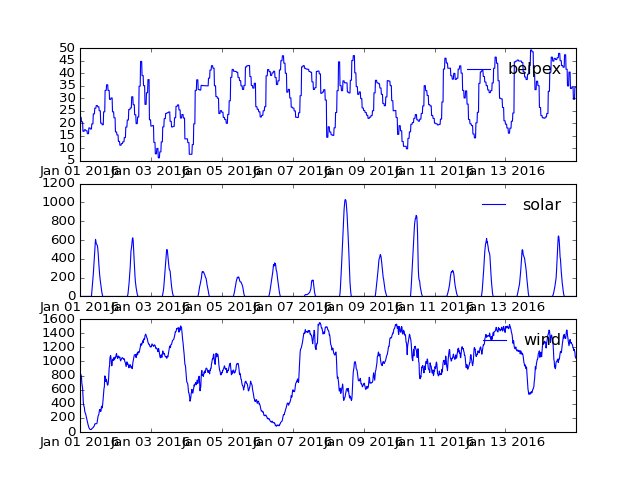

In [4]:
start = datetime.datetime(2016, 1, 1, 0, 0)
end = datetime.datetime(2016, 1, 14, 23, 45)

plt.figure()
plt.subplot(311)
plt.plot(data.belpex[start:end], label='belpex')
plt.legend(frameon=False)
plt.subplot(312)
plt.plot(data.solar[start:end], label='solar')
plt.legend(frameon=False)
plt.subplot(313)
plt.plot(data.wind[start:end], label='wind')
plt.legend(frameon=False)
plt.show()

<IPython.core.display.Javascript object>


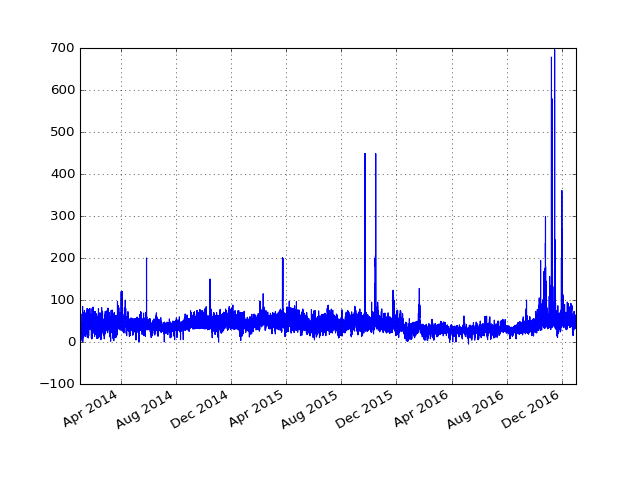

In [5]:
plt.figure()
data.belpex.plot(grid=True)
plt.show()

# Clean the data by removing outliers

Clue: Use a generic method from statistics that is independent of the timeseries

<IPython.core.display.Javascript object>


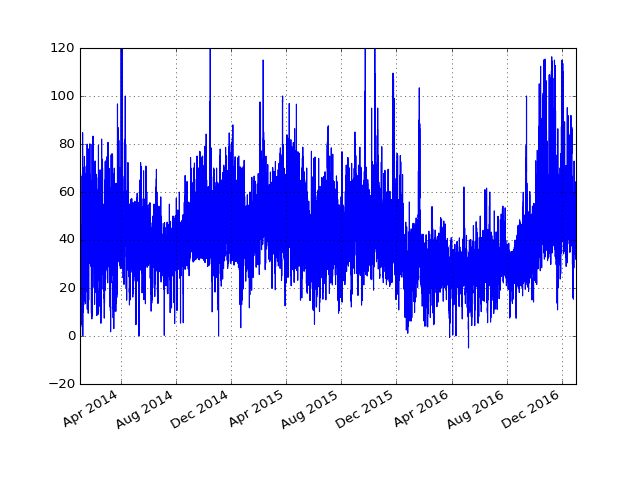

In [6]:
mean = data.belpex.mean()
std = data.belpex.std()
n_std = 4
data = data[((data.belpex <= mean + n_std*std) & (data.belpex >= mean - n_std*std))]
data.sort_index().head()


plt.figure()
data.belpex.plot(grid=True)
plt.show()

# Create boxplot

grouped by
* days in the week
* months
* hours
* years

http://pandas.pydata.org/pandas-docs/version/0.13.1/visualization.html

<IPython.core.display.Javascript object>


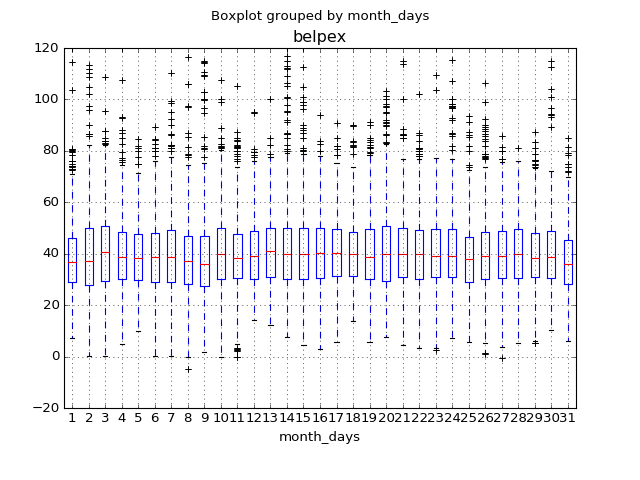

In [13]:
data['week_days']=data.index.weekday
data['month_days']=data.index.day
data['hours']=data.index.hour
data['months']=data.index.month
data['years'] =data.index.year

data.boxplot(column='belpex', by='month_days')

<IPython.core.display.Javascript object>


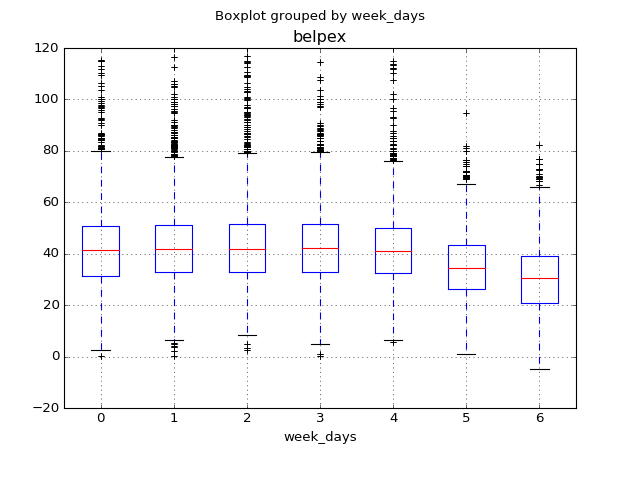

In [8]:
data.boxplot(column='belpex', by='week_days')

<IPython.core.display.Javascript object>


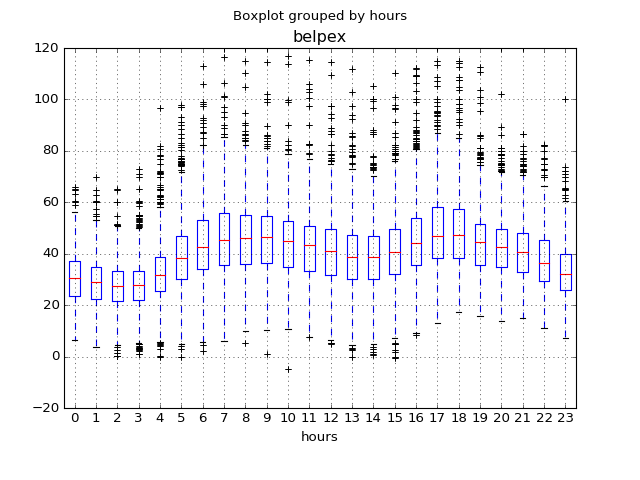

In [9]:
data.boxplot(column='belpex', by='hours')

<IPython.core.display.Javascript object>


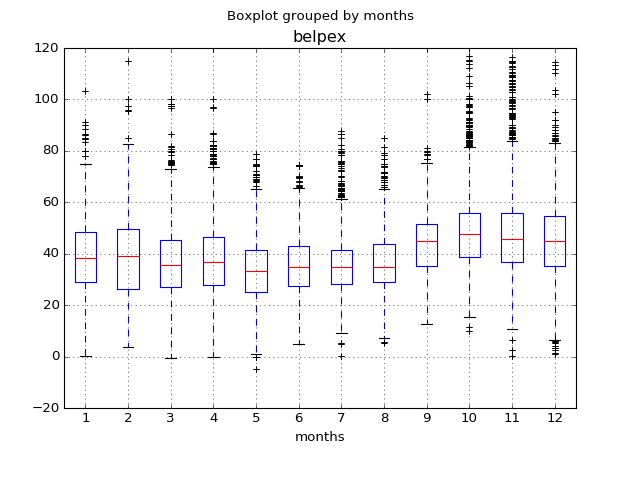

In [14]:
data.boxplot(column='belpex', by='months')

<IPython.core.display.Javascript object>


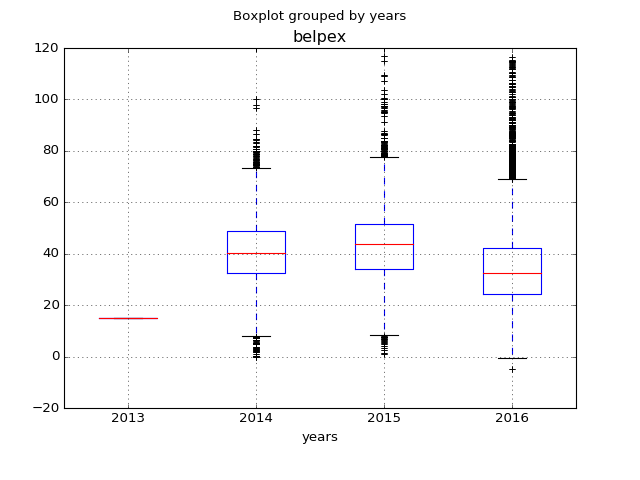

In [15]:
data.boxplot(column='belpex', by='years')

# Check for randomness in the time series using an autocorrelation plot

This is done by computing autocorrelations for data values at varying time lags. If time series is random, such autocorrelations should be near zero for any and all time-lag separations. If time series is non-random then one or more of the autocorrelations will be significantly non-zero. 

The autocorrelation is the correlation of a timeseries with a delayed copy of itself and is given by:
\begin{equation}
R(\tau) = \frac{E[(X_{t}-\mu)(X_{t+\tau}-\mu)]}{\sigma^2}
\end{equation}
where $X_t$ is the time series and $\tau$ is the time-lag.

How to make an autocorrelation plot using pandas in python:
http://pandas.pydata.org/pandas-docs/stable/visualization.html#visualization-autocorrelation

<IPython.core.display.Javascript object>


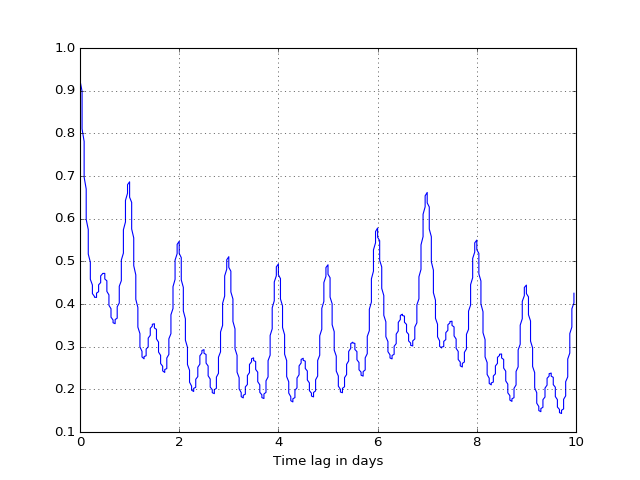

In [16]:
# Autocorrelation
lags = np.arange(1, 96*10)
acors = []
for lag in lags:
    acors.append(data.belpex.autocorr(lag))
plt.figure()
plt.plot(lags/4/24.0, acors)
plt.xlabel('Time lag in days')
plt.grid(True)

# Create a scatter matrix 

<IPython.core.display.Javascript object>


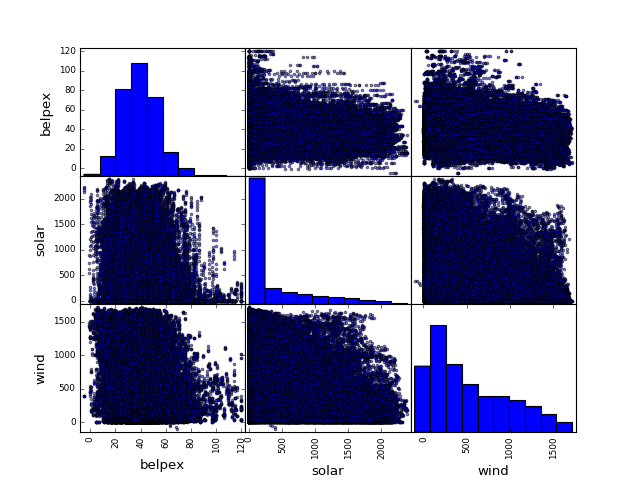

In [17]:
import pandas as pd
a = pd.scatter_matrix(data[['belpex', 'solar', 'wind']])

# Linear regression

In [36]:
from sklearn.linear_model import LinearRegression, Ridge
model = LinearRegression(normalize=True)
lags = [24*4] + list(range(96*7, 96*35, 96))
features = ['wind', 'solar']
print lags

[96, 672, 768, 864, 960, 1056, 1152, 1248, 1344, 1440, 1536, 1632, 1728, 1824, 1920, 2016, 2112, 2208, 2304, 2400, 2496, 2592, 2688, 2784, 2880, 2976, 3072, 3168, 3264]


In [37]:
index = data.index 
for lag in lags:
    data['belpex_lag_{}'.format(lag)] = data.belpex.shift(lag)
    features.append('belpex_lag_{}'.format(lag))
data['day_in_year'] = data.index.dayofyear
data = data.ix[index, ]
data = data.dropna()

X = data[features]
y = data.belpex

cv = KFold(n=len(data), n_folds=10, shuffle=False)
data['belpex_pred'] = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)

print(get_accuracy(data.belpex, data.belpex_pred))


0.15126484061


<IPython.core.display.Javascript object>


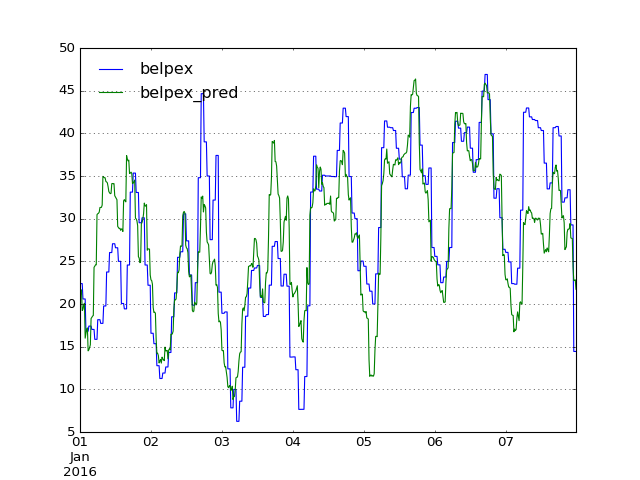

In [38]:
start = datetime.datetime(2016, 1, 1, 0, 0)
end = datetime.datetime(2016, 1, 7, 23, 45)

plt.figure()
data.belpex[start:end].plot(grid=True)
data.belpex_pred[start:end].plot(grid=True)
plt.legend(frameon=False,loc=2)
plt.show()